## IMPORT DATA

we import the dataset already with the feature enhancement, climate data, macro-economical variables.
In particular we enhanced with:
- features from one-hot encoded variables (years, countries, sectors), so to differentiate among them
- features on local geographical effects - considering macroeconomical and climate variables aggregates in ranges of 60 and 150 km. The distance was decided through averaging the centroids distances in Europe
- Aggregation of climate data to yearly granularity so to be able to compound the two datasets. In order to better integrate in the models such variables, we used max, mean and sum of the monthly observations

In [ ]:
import pandas as pd
import numpy as np
import math 
import json
import time 
import datetime
from collections import Counter 
from datetime import datetime,timedelta
import requests
import os
import pandas as pd
import time
from io import BytesIO

pd.options.display.max_rows = 200
pd.options.display.max_columns = 300

ecoclim = pd.read_excel("Economic_climate_data_2001_2022_yearly.xlsx")
ecoclim.info()

In [2]:
# ecoclim = mergefinal.merge(rescl, on = ["geo","year"], how = "left")
ecoclim.info()
ecoclim.dropna(axis = 1, inplace = True)
ecoclim.columns = ecoclim.columns.astype(str)

ecoclim

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39390 entries, 0 to 39389
Data columns (total 91 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            39390 non-null  int64  
 1   geo                                   39390 non-null  object 
 2   year                                  39390 non-null  int64  
 3   sector                                39390 non-null  object 
 4   employment                            39390 non-null  float64
 5   gross value added                     39390 non-null  float64
 6   area                                  39390 non-null  float64
 7   gdp                                   39390 non-null  float64
 8   population                            39390 non-null  float64
 9   country                               39390 non-null  object 
 10  regions_within_60km                   39390 non-null  object 
 11  regions_within_

Unnamed: 0    geo  year sector  employment  gross value added  \
0               0  AT111  2002      A        1.60              37.00   
1               1  AT111  2003      A        1.60              55.00   
2               2  AT111  2004      A        1.50              45.00   
3               3  AT111  2005      A        1.40              34.00   
4               4  AT111  2006      A        1.30              37.00   
...           ...    ...   ...    ...         ...                ...   
39385       39385  SK042  2014      C       53.53            2142.16   
39386       39386  SK042  2015      C       53.91            2179.43   
39387       39387  SK042  2016      C       54.81            2237.65   
39388       39388  SK042  2017      C       56.88            2258.92   
39389       39389  SK042  2018      C       56.11            2486.22   

              area       gdp  population country regions_within_60km  \
0       668.166746    627.48       37.73      AT   ['AT11', 'AT111']   
1       668.166746    674.62       37.65      AT   ['AT11', 'AT111']   
2       668.166746    676.25       37.58      AT   ['AT11', 'AT111']   
3       668.166746    669.25       37.45      AT   ['AT11', 'AT111']   
4       668.166746    714.72       37.45      AT   ['AT11', 'AT111']   
...            ...       ...         ...     ...                 ...   
39385  6754.000000   8854.64      795.15      SK   ['SK04', 'SK042']   
39386  6754.000000   9482.05      795.89      SK   ['SK04', 'SK042']   
39387  6754.000000   9350.63      797.38      SK   ['SK04', 'SK042']   
39388  6754.000000  10334.60      798.50      SK   ['SK04', 'SK042']   
39389  6754.000000  10702.43      799.60      SK   ['SK04', 'SK042']   

                                    regions_within_150km    empl150  \
0      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   7.513750   
1      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   7.132500   
2      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   6.841875   
3      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   6.599375   
4      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   6.401875   
...                                                  ...        ...   
39385  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  46.770000   
39386  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  47.855000   
39387  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  50.485000   
39388  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  52.645000   
39389  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  53.612500   

            gdp150      pop150  AT  BE  BG  CY  CZ  DE  DK  EE  EL  ES  FI  \
0      7678.171250  320.648750   1   0   0   0   0   0   0   0   0   0   0   
1      7862.706875  322.136875   1   0   0   0   0   0   0   0   0   0   0   
2      8225.823125  324.003750   1   0   0   0   0   0   0   0   0   0   0   
3      8587.190625  326.108125   1   0   0   0   0   0   0   0   0   0   0   
4      9032.411875  327.782500   1   0   0   0   0   0   0   0   0   0   0   
...            ...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
39385  5955.002500  711.937500   0   0   0   0   0   0   0   0   0   0   0   
39386  6440.772500  710.700000   0   0   0   0   0   0   0   0   0   0   0   
39387  6499.045000  709.735000   0   0   0   0   0   0   0   0   0   0   0   
39388  7088.242500  708.265000   0   0   0   0   0   0   0   0   0   0   0   
39389  7587.610000  706.205000   0   0   0   0   0   0   0   0   0   0   0   

       FR  HR  HU  IE  IT  LT  LU  LV  MT  NL  PL  PT  RO  SE  SI  SK  2002  \
0       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0     1   
1       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0     0   
2       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0     0   
3       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0     0   
4       0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0     0   
...    ..  ..

## Train/Test set 


In [4]:
from sklearn import preprocessing

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train1, X_test1, y_train, y_test = train_test_split(ecoclim[list(set(ecoclim.columns.to_list()) - set(['geo',"_merge",'year', 'sector','country', 'gross value added','regions_within_60km', 'regions_within_150km']))], ecoclim["gross value added"].to_list())

X_train1

temp_max_median_sum  heat_wave_count_sum  \
36054              265.279                    2   
17220              155.982                    0   
20562              194.921                    3   
16360                0.000                   12   
25136              158.869                    1   
...                    ...                  ...   
15575              174.375                   22   
11906              179.725                   10   
1598               192.719                    3   
18642              219.773                    0   
25629              229.708                    0   

       low_flow_index_monthly_max_sum  spi_12_median_max  2014  2002  DE  FI  \
36054                           0.000             1.2160     0     0   0   0   
17220                           0.000             1.4385     0     0   1   0   
20562                           0.000             1.0060     0     0   0   0   
16360                           0.000             1.4555     0     0   1   0   
25136                           1.276            -0.8210     0     0   0   0   
...                               ...                ...   ...   ...  ..  ..   
15575                           0.000             0.3060     0     0   1   0   
11906                           3.748             1.0480     0     0   1   0   
1598                            0.279             0.4890     0     0   0   0   
18642                           0.400             1.0605     0     0   0   0   
25629                           9.403            -1.0250     0     0   0   0   

       2009  spi_01_median_sum        gdp150  2015          area  RO  2006  C  \
36054     0            -3.8820  16379.174000     1   2220.000000   0     0  1   
17220     0            -6.1720   2564.202683     0    827.200383   0     0  1   
20562     0             0.2860   3873.616667     0  10395.186536   0     0  0   
16360     0            -9.3800  12470.940000     0     72.000000   0     0  0   
25136     0            -3.6820   5650.927143     0   5875.141261   0     0  1   
...     ...                ...           ...   ...           ...  ..   ... ..   
15575     0            -2.6560   6810.414500     1   2117.000000   0     0  0   
11906     0           -10.3360   6188.756818     0   1086.000000   0     0  0   
1598      0            -4.3955  14526.891538     0   1156.699741   0     0  0   
18642     0             3.4050   1105.352000     0   4169.476006   0     0  1   
25629     0            -4.4225  27431.235000     0   5972.698824   0     0  0   

       aggregate_heat_intensity_median_sum  2012  heat_wave_count_mean  \
36054                             4.257328     0              0.166667   
17220                             0.000000     0              0.000000   
20562                             4.862256     0              0.250000   
16360                            30.347282     0              1.000000   
25136                             1.627338     0              0.083333   
...                                    ...   ...                   ...   
15575                            48.575026     0              1.833333   
11906                            29.933414     0              0.833333   
1598                              3.831415     0              0.250000   
18642                             0.000000     0              0.000000   
25629                             0.000000     0              0.000000   

       aggregate_heat_intensity_median_max  population  spi_12_median_mean  \
36054                             2.926188      358.52           -0.143500   
17220                             0.000000      110.43            0.503500   
20562                             4.862256       91.90            0.547417   
16360                             9.520175       79.41           -0.065125   
25136                             1.627338      149.84           -1.361750   
...                                    ...         ...                 ...   
15575                    

In [5]:
X_train1.columns

Index(['temp_max_median_sum', 'heat_wave_count_sum',
       'low_flow_index_monthly_max_sum', 'spi_12_median_max', '2014', '2002',
       'DE', 'FI', '2009', 'spi_01_median_sum', 'gdp150', '2015', 'area', 'RO',
       '2006', 'C', 'aggregate_heat_intensity_median_sum', '2012',
       'heat_wave_count_mean', 'aggregate_heat_intensity_median_max',
       'population', 'spi_12_median_mean', '2018', 'BG', 'AT', '2008',
       'heat_wave_count_max', 'LT', '2016', 'PL', 'HR', 'spi_03_median_max',
       'IE', 'DK', 'spi_03_median_sum', 'spi_06_median_max', 'NL', 'HU',
       'employment', 'FR', 'spi_06_median_sum', '2010',
       'soil_moisture_anomaly_median_sum', 'CY', 'IT', '2007',
       'aggregate_heat_intensity_median_mean', 'LV', '2017', 'A', 'SK', '2005',
       'LU', '2011', 'SI', 'spi_03_median_mean', 'gdp', 'spi_12_median_sum',
       'Unnamed: 0', 'MT', 'spi_01_median_mean', 'apara_median_sum', '2004',
       'SE', 'spi_06_median_mean', '2013', 'empl150', 'ES', 'BE', 'CZ', 'PT',


In [6]:
X_test1.columns

Index(['temp_max_median_sum', 'heat_wave_count_sum',
       'low_flow_index_monthly_max_sum', 'spi_12_median_max', '2014', '2002',
       'DE', 'FI', '2009', 'spi_01_median_sum', 'gdp150', '2015', 'area', 'RO',
       '2006', 'C', 'aggregate_heat_intensity_median_sum', '2012',
       'heat_wave_count_mean', 'aggregate_heat_intensity_median_max',
       'population', 'spi_12_median_mean', '2018', 'BG', 'AT', '2008',
       'heat_wave_count_max', 'LT', '2016', 'PL', 'HR', 'spi_03_median_max',
       'IE', 'DK', 'spi_03_median_sum', 'spi_06_median_max', 'NL', 'HU',
       'employment', 'FR', 'spi_06_median_sum', '2010',
       'soil_moisture_anomaly_median_sum', 'CY', 'IT', '2007',
       'aggregate_heat_intensity_median_mean', 'LV', '2017', 'A', 'SK', '2005',
       'LU', '2011', 'SI', 'spi_03_median_mean', 'gdp', 'spi_12_median_sum',
       'Unnamed: 0', 'MT', 'spi_01_median_mean', 'apara_median_sum', '2004',
       'SE', 'spi_06_median_mean', '2013', 'empl150', 'ES', 'BE', 'CZ', 'PT',


In [7]:

import sklearn
from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
   
}
xgb = GradientBoostingRegressor(**params)
xgb.fit(X_train1, y_train)
xgb.score(X_test1,y_test)
# print(y_test)
def perc_err(y_pred, y_true):
    abs_err = abs(y_pred - y_true)/y_pred
    sum_abs_err = np.sum(abs_err)
    loss = sum_abs_err / len(y_true) *100
    return loss

# print(xgb.predict(X_test1))
mse = sklearn.metrics.mean_squared_error(y_test, xgb.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost',max(0,rmse)) 
perc_err(xgb.predict(X_test1),y_test)



The mean squared error (MSE) on test set: 297452.8498
RMSE for xgboost 545.3923815454384


32.09869946530419

## XGBOOST

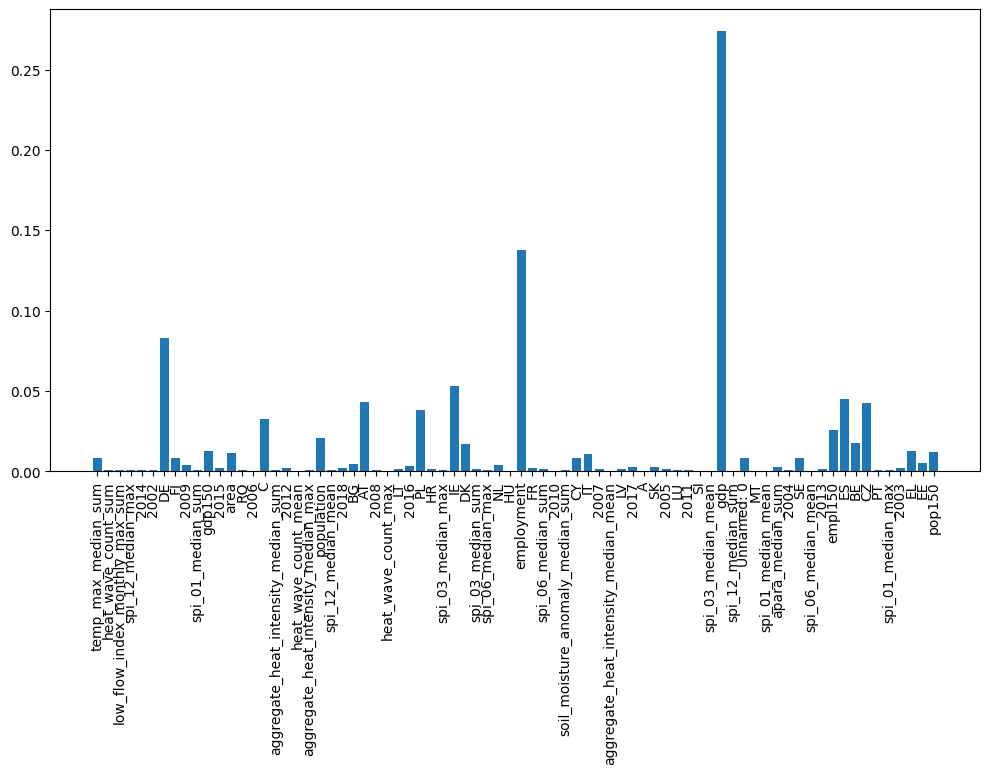

In [8]:

# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot
# load data
# split data into X and y

# fit model no training data
model = XGBRegressor()
model.fit(X_train1, y_train)
# feature importance
# print(model.feature_importances_)
# plot
pyplot.figure(figsize=(12, 6))
pyplot.bar(X_train1.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()





In [9]:
# print(model.score(X_test1,y_test))
# print(y_test)
def perc_err(y_pred, y_true):
    abs_err = abs(y_pred - y_true)/y_pred
    sum_abs_err = np.sum(abs_err)
    loss = sum_abs_err / len(y_true) *100
    return loss

predicted = xgb.predict(X_test1)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost',max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)

The mean squared error (MSE) on test set: 228154.6725
RMSE for xgboost 477.6553909405655


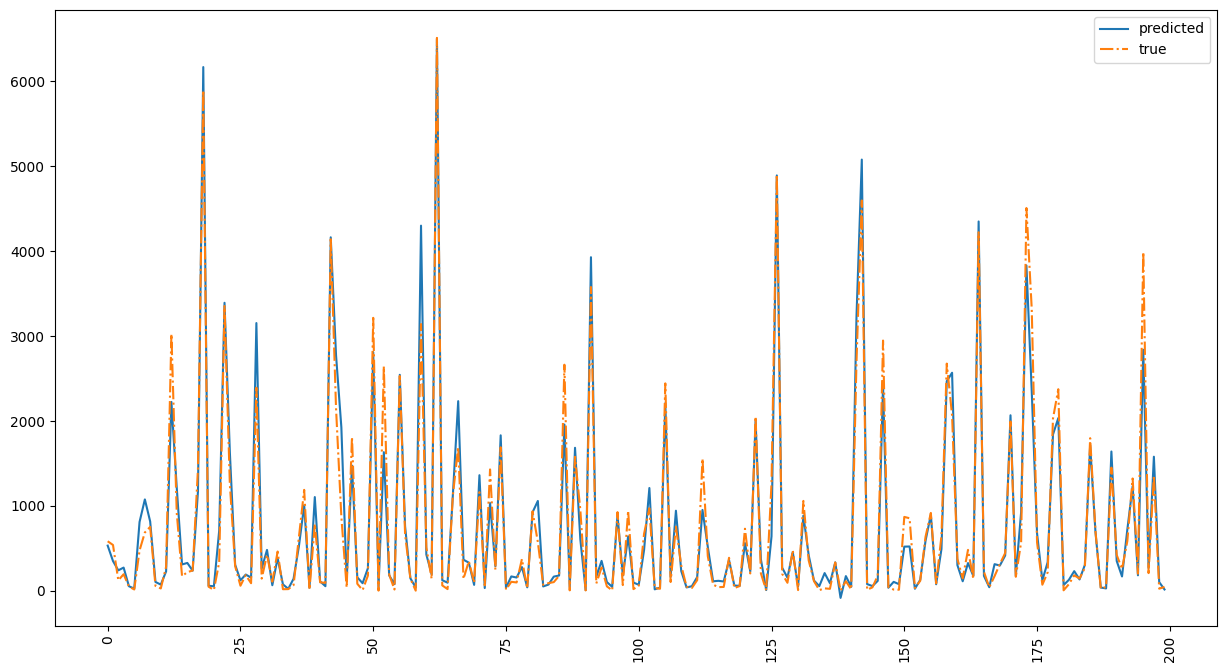

In [10]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (15,8))
plt.plot(range(X_test1.DE.head(200).count()), predicted[:200],label = "predicted")
plt.plot(range(X_test1.DE.head(200).count()), y_test[:200],'-.', label ='true')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

## XGBOOST by country

In [4]:
from sklearn import preprocessing
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X_tr = []
X_te = []
y_tr = []
y_te = []
countries = ecoclim["country"].drop_duplicates().to_list()
for country in countries: 
    X_train1, X_test1, y_train, y_test = train_test_split(ecoclim.loc[ecoclim['country'] == country ,list(set(ecoclim.columns.to_list()) - set(['geo','AT',
 'BE',
 'BG',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'MT',
 'NL',
 'PL',
 'PT',
 'RO',
 'SE',
 'SI',
 'SK',"_merge",'year', 'sector', 'gross value added','regions_within_60km', 'regions_within_150km']))], ecoclim.loc[ecoclim['country'] == country ,"gross value added"].to_list())
    X_tr.append(X_train1)
    X_te.append(X_test1)
    y_tr.append(y_train)
    y_te.append(y_test)

X_tr[0]

aggregate_heat_intensity_median_max  2002  2011  A  spi_03_median_max  \
189                             13.732659     0     0  0             1.4880   
666                              0.000000     0     0  0             1.1060   
32                               3.502128     0     0  0             0.9985   
859                              7.305626     0     1  1            -0.0845   
449                              2.178665     0     0  1             1.9100   
...                                   ...   ...   ... ..                ...   
1088                             1.234878     1     0  1             1.4580   
975                              2.404822     0     0  0             0.9010   
878                              7.102250     0     0  0             1.1760   
536                              5.517719     0     1  0            -0.4200   
765                              6.582950     1     0  0             3.5740   

      spi_06_median_sum      pop150  2016  low_flow_index_monthly_max_sum  \
189              3.4995  311.560000     0                           0.000   
666             -1.9130  166.513846     0                           1.994   
32             -10.2805  347.053750     0                           0.000   
859            -14.1765  154.114615     0                           0.671   
449             11.1830  191.200000     0                           0.146   
...                 ...         ...   ...                             ...   
1088             3.4610  229.852632     0                           0.000   
975              2.3040  147.993500     0                           0.000   
878              7.7165  154.430769     0                           0.000   
536            -19.0745  218.982667     0                           2.111   
765             17.6960  243.850833     0                           0.000   

      2015  2009  2013  2004        gdp150  2017  spi_06_median_mean  C  \
189      0     0     0     1   9475.614167     0            0.291625  1   
666      0     0     0     0   4377.176923     0           -0.159417  1   
32       0     0     0     0  12262.945000     1           -0.856708  1   
859      0     0     0     0   5086.856154     0           -1.181375  0   
449      0     1     0     0   4732.067500     0            0.931917  0   
...    ...   ...   ...   ...           ...   ...                 ... ..   
1088     0     0     0     0   9334.884737     0            0.288417  0   
975      0     0     0     0   5011.108000     0            0.192000  1   
878      0     0     1     0   5291.678462     0            0.643042  1   
536      0     0     0     0   8219.564000     0           -1.589542  1   
765      0     0     0     0   5200.579167     0            1.474667  1   

      aggregate_heat_intensity_median_sum  spi_06_median_max  2010  \
189                             13.732659             1.3475     0   
666                              0.000000             0.4980     0   
32                               3.502128             0.3015     0   
859                              7.305626             0.3590     0   
449                              2.178665             1.4740     0   
...                                   ...                ...   ...   
1088                             1.234878             1.5590     0   
975                              3.236936             1.1015     0   
878                              9.414183             1.5290     0   
536                              5.517719            -0.6450     0   
765                             10.050690             3.3375     0   

             area      gdp country  spi_12_median_sum  2006  \
189   1172.713605  4202.16      AT            -2.2925     0   
666   3066.755828  2328.30      AT            -0.6030     0   
32     701.000000   997.92      AT           -10.1355     0   
859    955.180383   590.18      AT           -13.4485     0   
449   3439.542402  3639.39      AT            16.1890     0   
...         

In [5]:
X_tr[1]

aggregate_heat_intensity_median_max  2002  2011  A  spi_03_median_max  \
1758                             0.789727     0     1  1             1.4600   
1623                            14.313310     0     0  1             1.4815   
1467                             4.689671     0     0  1             1.2260   
1925                             8.724865     0     0  0             1.3745   
2092                             1.470714     0     0  1             1.1640   
...                                   ...   ...   ... ..                ...   
2315                             4.221728     0     0  1             1.5345   
1259                             4.653069     0     0  1             1.1650   
2091                             2.968683     0     0  1             1.3710   
2126                             2.330554     0     1  1             1.1570   
1922                             0.000000     0     0  0             1.7405   

      spi_06_median_sum      pop150  2016  low_flow_index_monthly_max_sum  \
1758            -3.0230  391.838889     0                           2.277   
1623             1.9190  374.705652     0                           0.000   
1467             4.4235  372.999677     0                           0.144   
1925            -6.0025  361.650000     0                           0.000   
2092            -5.7480  348.314615     0                           0.920   
...                 ...         ...   ...                             ...   
2315             7.1485  126.973750     0                           0.000   
1259             1.1665  370.286111     0                           0.954   
2091             4.0180  319.466667     0                           0.000   
2126            -5.6770  280.271429     0                           5.288   
1922             6.7985  340.069259     0                           0.000   

      2015  2009  2013  2004        gdp150  2017  spi_06_median_mean  C  \
1758     0     0     0     0  11022.364444     0           -0.251917  0   
1623     0     0     0     1  11329.680000     0            0.159917  0   
1467     0     0     0     0  12655.027742     0            0.368625  0   
1925     0     0     0     0  14179.808889     0           -0.500208  1   
2092     0     1     0     0  11882.327692     0           -0.479000  0   
...    ...   ...   ...   ...           ...   ...                 ... ..   
2315     0     0     0     0   4613.553125     0            0.595708  0   
1259     0     0     0     0  13164.392778     0            0.097208  0   
2091     0     0     0     0  10684.216364     0            0.334833  0   
2126     0     0     0     0  10057.860714     0           -0.473083  0   
1922     0     0     0     0  10792.425926     0            0.566542  1   

      aggregate_heat_intensity_median_sum  spi_06_median_max  2010  \
1758                             1.462537             1.6820     0   
1623                            14.313310             0.8195     0   
1467                             4.689671             1.6170     0   
1925                            19.771592             1.1235     0   
2092                             1.470714             0.2570     0   
...                                   ...                ...   ...   
2315                             4.221728             1.6865     0   
1259                             4.653069             1.2570     0   
2091                             2.968683             1.5600     0   
2126                             3.476571             1.3850     0   
1922                             0.000000             1.3370     0   

             area       gdp country  spi_12_median_sum  2006  \
1758   316.935518   3861.58      BE             0.4080     0   
1623   637.964310   7380.33      BE            -4.7835     0   
1467  1012.508480  19226.20      BE             5.9165     0   
1925   589.000000   6696.86      BE            -3.7570     0   
2092   380.334302   1126.69      BE            -4.9220     0   
...   

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 3420 to 3410
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   aggregate_heat_intensity_median_max   25 non-null     float64
 1   2002                                  25 non-null     int64  
 2   2011                                  25 non-null     int64  
 3   A                                     25 non-null     int64  
 4   spi_03_median_max                     25 non-null     float64
 5   spi_06_median_sum                     25 non-null     float64
 6   pop150                                25 non-null     float64
 7   2016                                  25 non-null     int64  
 8   low_flow_index_monthly_max_sum        25 non-null     float64
 9   2015                                  25 non-null     int64  
 10  2009                                  25 non-null     int64  
 11  2013                 

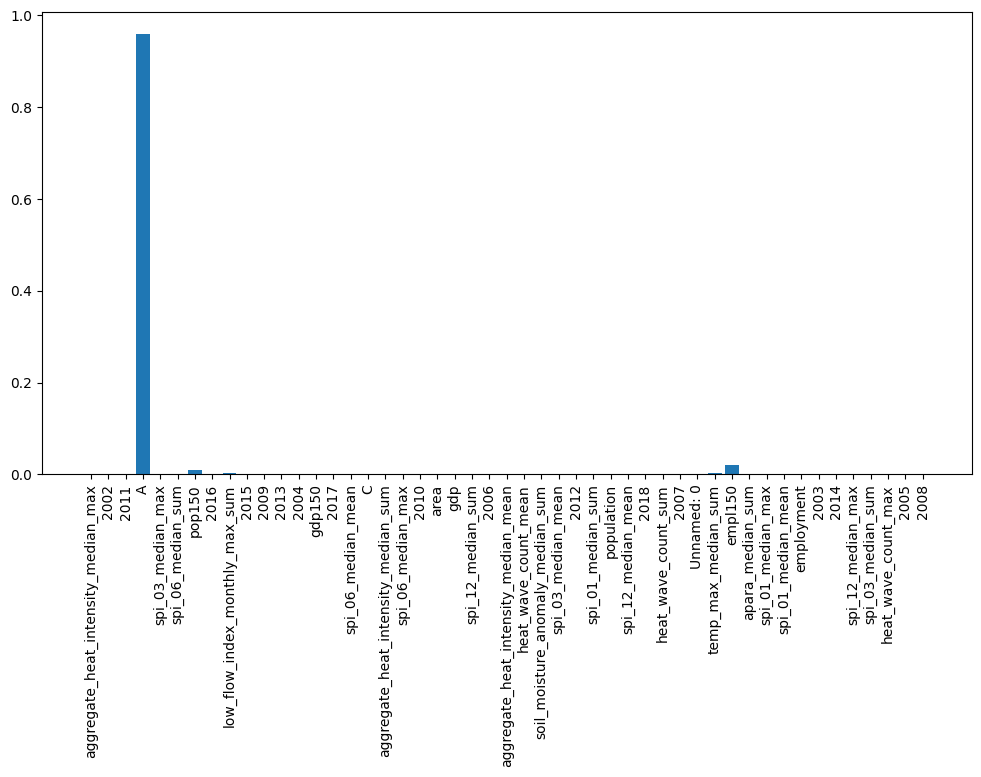

aggregate_heat_intensity_median_max   7.8038414e-05
2002   0.0018444344
2011   0.001531403
A   0.9583365
spi_03_median_max   0.00028000856
spi_06_median_sum   5.1506518e-06
pop150   0.008757614
2016   0.0
low_flow_index_monthly_max_sum   0.003132463
2015   0.0010787376
2009   0.0
2013   1.9861902e-07
2004   0.0
gdp150   0.0002955041
2017   1.00306046e-07
spi_06_median_mean   0.0
C   0.0
aggregate_heat_intensity_median_sum   1.0917487e-09
spi_06_median_max   0.00023054436
2010   0.0
area   0.0
gdp   0.0
spi_12_median_sum   6.8099616e-05
2006   2.9361416e-10
aggregate_heat_intensity_median_mean   0.0
heat_wave_count_mean   0.0
soil_moisture_anomaly_median_sum   8.085547e-07
spi_03_median_mean   0.00030745118
2012   0.0
spi_01_median_sum   0.0
population   0.0
spi_12_median_mean   0.0
2018   0.0
heat_wave_count_sum   0.0
2007   3.4858225e-05
Unnamed: 0   0.0010978576
temp_max_median_sum   0.0030176416
empl150   0.01989954
apara_median_sum   0.0
spi_01_median_max   9.65372e-09
spi_01_media

XGBoostError: [13:55:10] /workspace/src/c_api/c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.
Stack trace:
  [bt] (0) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15c2ca) [0x7f10f0fee2ca]
  [bt] (1) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixGetStrFeatureInfo+0x33f) [0x7f10f0ffc11f]
  [bt] (2) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f11a61a0a4a]
  [bt] (3) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f11a619ffea]
  [bt] (4) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f11a622f461]
  [bt] (5) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7f11a62256eb]
  [bt] (6) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyObject_MakeTpCall+0x26b) [0x563017e75a6b]
  [bt] (7) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyEval_EvalFrameDefault+0x54a6) [0x563017e719d6]
  [bt] (8) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(+0x14f299) [0x563017e87299]



In [7]:
i= 3
# ['AT',
#  'BE',
#  'BG',
#  'CY',
#  'CZ',
#  'DE',
country = "CY"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

import sklearn
predicted = model.predict(X_te[i].drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


<class 'pandas.core.frame.DataFrame'>
Index: 2728 entries, 31229 to 28947
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   aggregate_heat_intensity_median_max   2728 non-null   float64
 1   2002                                  2728 non-null   int64  
 2   2011                                  2728 non-null   int64  
 3   A                                     2728 non-null   int64  
 4   spi_03_median_max                     2728 non-null   float64
 5   spi_06_median_sum                     2728 non-null   float64
 6   pop150                                2728 non-null   float64
 7   2016                                  2728 non-null   int64  
 8   low_flow_index_monthly_max_sum        2728 non-null   float64
 9   2015                                  2728 non-null   int64  
 10  2009                                  2728 non-null   int64  
 11  2013             

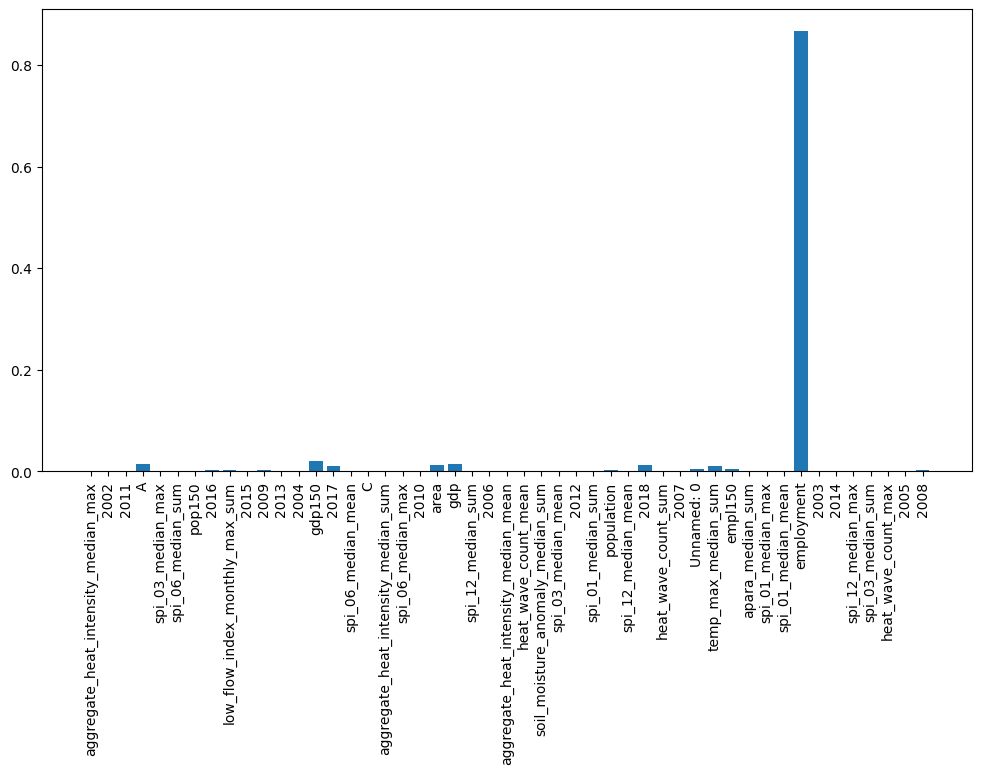

aggregate_heat_intensity_median_max   0.00031746287
2002   0.00013678403
2011   5.941633e-05
A   0.014394188
spi_03_median_max   0.000582666
spi_06_median_sum   0.00028748982
pop150   0.0013546265
2016   0.002950396
low_flow_index_monthly_max_sum   0.002004743
2015   0.00063951197
2009   0.0025756855
2013   0.00050100853
2004   0.00045966706
gdp150   0.020144774
2017   0.010568938
spi_06_median_mean   0.0
C   0.0
aggregate_heat_intensity_median_sum   0.0006189272
spi_06_median_max   0.000626253
2010   0.0006594176
area   0.012620423
gdp   0.014351007
spi_12_median_sum   0.0009649535
2006   0.00014114728
aggregate_heat_intensity_median_mean   0.0
heat_wave_count_mean   0.0011496583
soil_moisture_anomaly_median_sum   0.00042256736
spi_03_median_mean   0.00025832502
2012   0.0014128932
spi_01_median_sum   0.00012669245
population   0.0019201303
spi_12_median_mean   0.0
2018   0.012882369
heat_wave_count_sum   0.0
2007   0.00089591614
Unnamed: 0   0.00404748
temp_max_median_sum   0.0104783

XGBoostError: [13:56:42] /workspace/src/c_api/c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.
Stack trace:
  [bt] (0) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15c2ca) [0x7f10f0fee2ca]
  [bt] (1) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixGetStrFeatureInfo+0x33f) [0x7f10f0ffc11f]
  [bt] (2) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f11a61a0a4a]
  [bt] (3) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f11a619ffea]
  [bt] (4) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f11a622f461]
  [bt] (5) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7f11a62256eb]
  [bt] (6) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyObject_MakeTpCall+0x26b) [0x563017e75a6b]
  [bt] (7) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyEval_EvalFrameDefault+0x54a6) [0x563017e719d6]
  [bt] (8) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(+0x14f299) [0x563017e87299]



In [8]:
i= 15
['AT',
 'BE',
 'BG',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'MT',
 'NL',
 'PL',
 'PT',
 'RO',
 'SE',
 'SI',
 'SK']
country = "IT"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

import sklearn
predicted = model.predict(X_te[i].drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


<class 'pandas.core.frame.DataFrame'>
Index: 10225 entries, 7755 to 9160
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   aggregate_heat_intensity_median_max   10225 non-null  float64
 1   2002                                  10225 non-null  int64  
 2   2011                                  10225 non-null  int64  
 3   A                                     10225 non-null  int64  
 4   spi_03_median_max                     10225 non-null  float64
 5   spi_06_median_sum                     10225 non-null  float64
 6   pop150                                10225 non-null  float64
 7   2016                                  10225 non-null  int64  
 8   low_flow_index_monthly_max_sum        10225 non-null  float64
 9   2015                                  10225 non-null  int64  
 10  2009                                  10225 non-null  int64  
 11  2013              

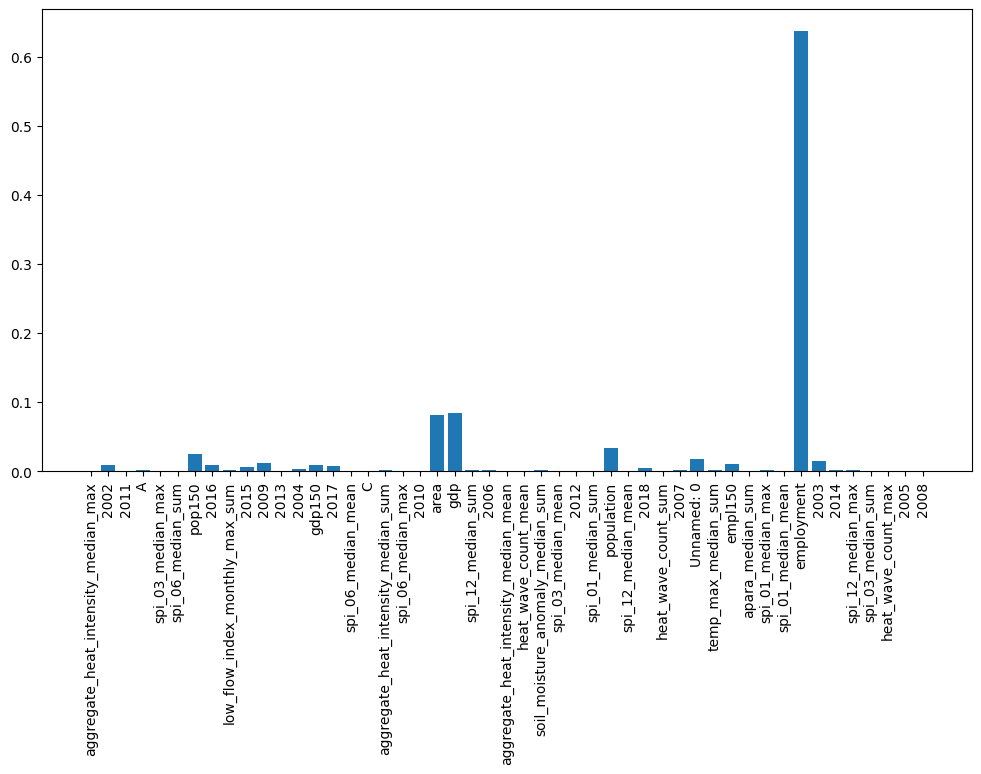

aggregate_heat_intensity_median_max   0.00067217834
2002   0.00888493
2011   0.00027939072
A   0.0016699139
spi_03_median_max   0.0006104237
spi_06_median_sum   0.0005713475
pop150   0.025414875
2016   0.009312585
low_flow_index_monthly_max_sum   0.0022966266
2015   0.0064676516
2009   0.012520789
2013   0.00029403614
2004   0.004108785
gdp150   0.009135464
2017   0.007245811
spi_06_median_mean   0.0
C   0.0
aggregate_heat_intensity_median_sum   0.0014984452
spi_06_median_max   0.00127657
2010   0.00047874986
area   0.08228339
gdp   0.084278226
spi_12_median_sum   0.0017436835
2006   0.0017695846
aggregate_heat_intensity_median_mean   0.0
heat_wave_count_mean   0.0003791293
soil_moisture_anomaly_median_sum   0.0016682635
spi_03_median_mean   0.000805458
2012   0.00042048146
spi_01_median_sum   0.00068858475
population   0.03370497
spi_12_median_mean   0.0
2018   0.0050938497
heat_wave_count_sum   0.0
2007   0.001417494
Unnamed: 0   0.018617086
temp_max_median_sum   0.0025598567
empl150

XGBoostError: [13:54:38] /workspace/src/c_api/c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.
Stack trace:
  [bt] (0) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15c2ca) [0x7f10f0fee2ca]
  [bt] (1) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixGetStrFeatureInfo+0x33f) [0x7f10f0ffc11f]
  [bt] (2) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f11a61a0a4a]
  [bt] (3) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f11a619ffea]
  [bt] (4) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f11a622f461]
  [bt] (5) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7f11a62256eb]
  [bt] (6) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyObject_MakeTpCall+0x26b) [0x563017e75a6b]
  [bt] (7) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyEval_EvalFrameDefault+0x54a6) [0x563017e719d6]
  [bt] (8) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(+0x14f299) [0x563017e87299]



In [6]:
i= 5
# ['AT',
#  'BE',
#  'BG',
#  'CY',
#  'CZ',
#  'DE',
country = "DE"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

import sklearn
predicted = model.predict(X_te[i].drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 1693 to 1964
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   2010                                  936 non-null    int64  
 1   soil_moisture_anomaly_median_sum      936 non-null    float64
 2   temp_max_median_sum                   936 non-null    float64
 3   heat_wave_count_sum                   936 non-null    int64  
 4   low_flow_index_monthly_max_sum        936 non-null    float64
 5   spi_12_median_max                     936 non-null    float64
 6   2014                                  936 non-null    int64  
 7   2002                                  936 non-null    int64  
 8   2007                                  936 non-null    int64  
 9   aggregate_heat_intensity_median_mean  936 non-null    float64
 10  2009                                  936 non-null    int64  
 11  2017                

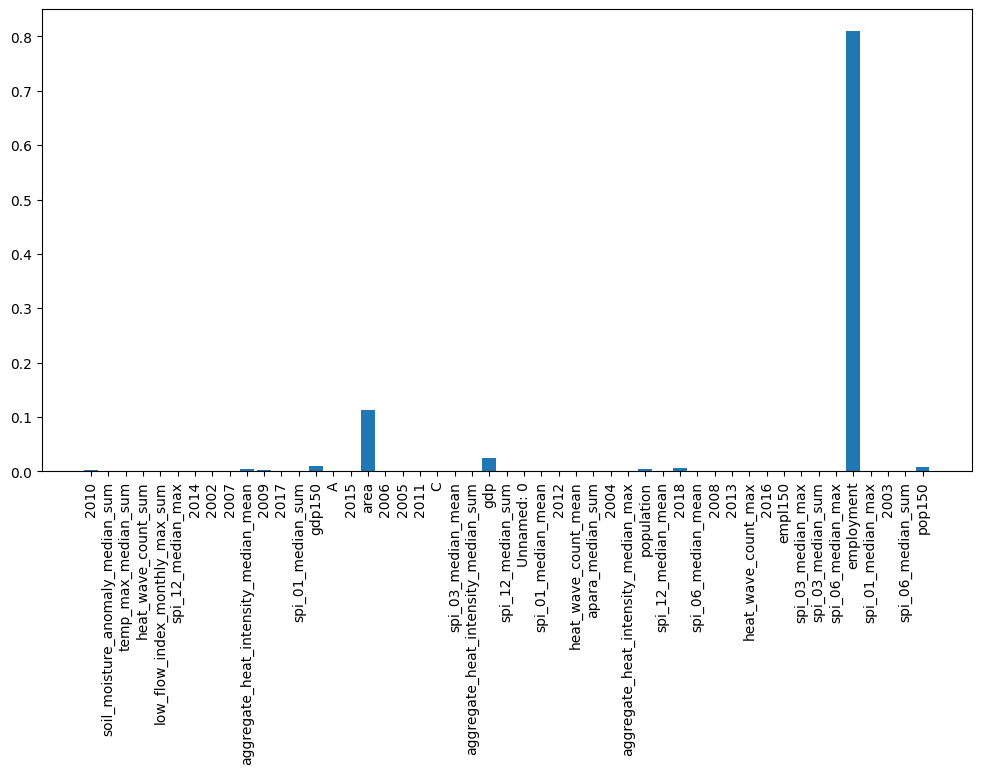

2010   0.0016864492
soil_moisture_anomaly_median_sum   0.00027764923
temp_max_median_sum   0.00045754004
heat_wave_count_sum   0.0008623351
low_flow_index_monthly_max_sum   0.0014847798
spi_12_median_max   0.0009278318
2014   3.6497474e-06
2002   0.0
2007   8.771069e-05
aggregate_heat_intensity_median_mean   0.0045705433
2009   0.0021186317
2017   0.00056249223
spi_01_median_sum   0.0010667893
gdp150   0.009787112
A   0.00019445547
2015   0.00024524465
area   0.112301774
2006   7.573228e-07
2005   0.0003144671
2011   0.0012127948
C   0.0
spi_03_median_mean   0.0011544824
aggregate_heat_intensity_median_sum   0.0
gdp   0.0254015
spi_12_median_sum   0.0001399613
Unnamed: 0   0.0013627011
spi_01_median_mean   0.0
2012   8.972162e-05
heat_wave_count_mean   0.0
apara_median_sum   0.0009079826
2004   3.6819204e-06
aggregate_heat_intensity_median_max   0.00022786844
population   0.0039287894
spi_12_median_mean   0.0
2018   0.0053624213
spi_06_median_mean   0.00021307517
2008   0.00018322829
2

XGBoostError: [13:47:42] /workspace/src/c_api/c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.
Stack trace:
  [bt] (0) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15c2ca) [0x7f6ebbc052ca]
  [bt] (1) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixGetStrFeatureInfo+0x33f) [0x7f6ebbc1311f]
  [bt] (2) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f6f716f4a4a]
  [bt] (3) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f6f716f3fea]
  [bt] (4) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f6f71783461]
  [bt] (5) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7f6f717796eb]
  [bt] (6) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyObject_MakeTpCall+0x26b) [0x55d7c0395a6b]
  [bt] (7) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyEval_EvalFrameDefault+0x54a6) [0x55d7c03919d6]
  [bt] (8) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(+0x14f299) [0x55d7c03a7299]



In [16]:
i= 1
country = "BE"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

import sklearn
predicted = model.predict(X_te[i].drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


In [13]:
i= 0
country = "AT"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])


<class 'pandas.core.frame.DataFrame'>
Index: 892 entries, 693 to 385
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   2010                                  892 non-null    int64  
 1   soil_moisture_anomaly_median_sum      892 non-null    float64
 2   temp_max_median_sum                   892 non-null    float64
 3   heat_wave_count_sum                   892 non-null    int64  
 4   low_flow_index_monthly_max_sum        892 non-null    float64
 5   spi_12_median_max                     892 non-null    float64
 6   2014                                  892 non-null    int64  
 7   2002                                  892 non-null    int64  
 8   2007                                  892 non-null    int64  
 9   aggregate_heat_intensity_median_mean  892 non-null    float64
 10  2009                                  892 non-null    int64  
 11  2017                  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

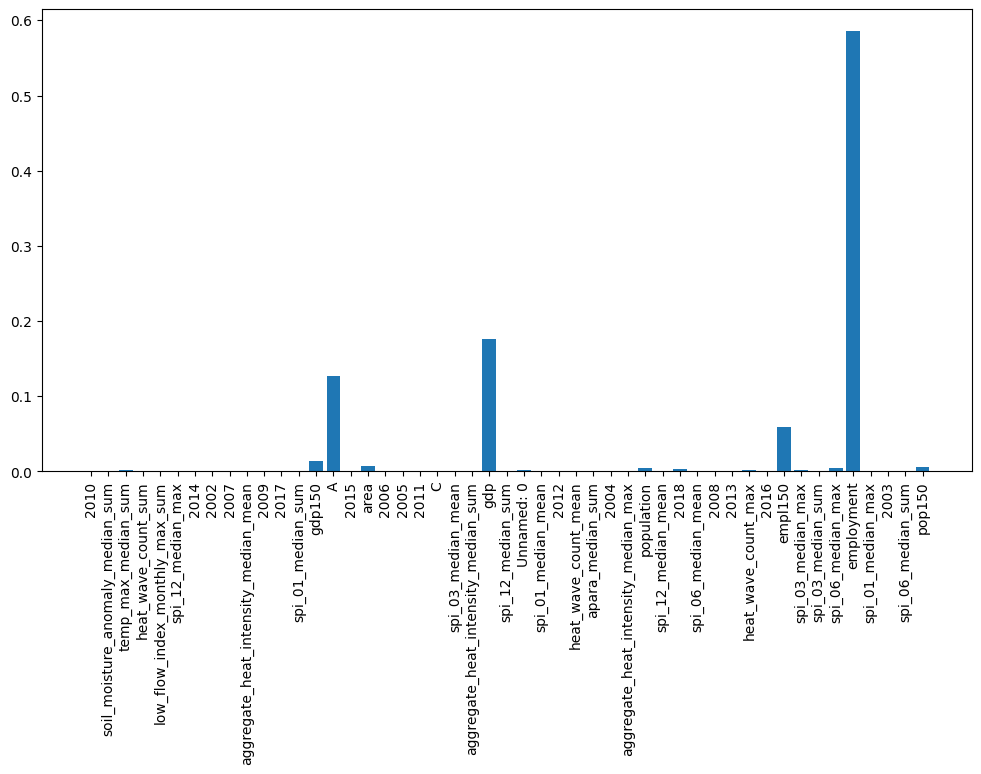

2010   7.346376e-06
soil_moisture_anomaly_median_sum   0.00031555237
temp_max_median_sum   0.0017364357
heat_wave_count_sum   0.00016108737
low_flow_index_monthly_max_sum   0.00043339143
spi_12_median_max   0.00016603059
2014   5.006789e-05
2002   0.0005434694
2007   6.0437783e-06
aggregate_heat_intensity_median_mean   0.00048977457
2009   0.00039652234
2017   0.00095792377
spi_01_median_sum   0.00047705256
gdp150   0.014025592
A   0.12650485
2015   0.00015345454
area   0.0070618317
2006   0.00044113238
2005   2.9794279e-05
2011   4.1186042e-05
C   0.0
spi_03_median_mean   6.151947e-05
aggregate_heat_intensity_median_sum   0.0
gdp   0.1761843
spi_12_median_sum   0.0001223649
Unnamed: 0   0.0015589327
spi_01_median_mean   0.0
2012   1.6165503e-05
heat_wave_count_mean   0.0
apara_median_sum   0.00039704563
2004   0.0007381852
aggregate_heat_intensity_median_max   0.00018869016
population   0.004625054
spi_12_median_mean   0.0
2018   0.0036314188
spi_06_median_mean   8.553772e-05
2008   3

In [14]:
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

In [14]:
import sklearn
predicted = model.predict(X_te[i])#.drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i]))#.drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


The mean squared error (MSE) on test set: 11536.0199
RMSE for xgboost AT     107.40586539814697


In [15]:
countries

['AT',
 'BE',
 'BG',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'MT',
 'NL',
 'PL',
 'PT',
 'RO',
 'SE',
 'SI',
 'SK']

In [ ]:
model_list = []
for i, country in enumerate(countries):
    # fit model no training data
    model = XGBRegressor()
    model.fit(X_tr[i].drop(columns = ["country"], inplace = True), y_tr[i])
    model_list.append(model)
    pyplot.figure(figsize=(12, 6))
    pyplot.bar(X_tr[i].columns, model.feature_importances_)
    pyplot.xticks(rotation=90)
    pyplot.show()

#     predicted = xgb.predict(X_te[i].drop(columns = ["country"], inplace = True))
#     mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
#     print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
#     rmse = math.sqrt(mse)
#     print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
#     # perc_err(model.predict(X_test1),y_test)



In [ ]:
# prophet

In [164]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Sample data with date, target variable 'y', categorical predictor 'category', and numerical predictor 'numerical'
dfprophet = ecoclim[list(set(ecoclim.columns.to_list()) - set(['2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 'A',
 'AT',
 'BE',
 'BG',
 'C',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'MT',
 'NL',
 'PL',
 'PT',
 'RO',
 'SE',
 'SI',
 'SK','geo',"_merge", 'sector', 'regions_within_60km', 'regions_within_150km']))]
dfprophet.columns

Index(['soil_moisture_anomaly_median_sum', 'area', 'year', 'spi_03_median_max',
       'spi_12_median_max', 'spi_12_median_mean', 'population',
       'aggregate_heat_intensity_median_mean', 'heat_wave_count_sum',
       'heat_wave_count_mean', 'employment', 'pop150', 'spi_06_median_sum',
       'spi_03_median_mean', 'gross value added', 'spi_12_median_sum',
       'spi_01_median_max', 'empl150', 'low_flow_index_monthly_max_sum',
       'gdp150', 'country', 'heat_wave_count_max', 'spi_03_median_sum',
       'temp_max_median_sum', 'spi_01_median_sum',
       'aggregate_heat_intensity_median_sum', 'apara_median_sum', 'gdp',
       'spi_06_median_max', 'spi_01_median_mean',
       'aggregate_heat_intensity_median_max', 'spi_06_median_mean'],
      dtype='object')

In [166]:
dfprophet.columns = ['soil_moisture_anomaly_median_sum', 'area', 'ds', 'spi_03_median_max',
       'spi_12_median_max', 'spi_12_median_mean', 'population',
       'aggregate_heat_intensity_median_mean', 'heat_wave_count_sum',
       'heat_wave_count_mean', 'employment', 'pop150', 'spi_06_median_sum',
       'spi_03_median_mean', 'y', 'spi_12_median_sum',
       'spi_01_median_max', 'empl150', 'low_flow_index_monthly_max_sum',
       'gdp150',"country", 'heat_wave_count_max', 'spi_03_median_sum',
       'temp_max_median_sum', 'spi_01_median_sum',
       'aggregate_heat_intensity_median_sum', 'apara_median_sum', 'gdp',
       'spi_06_median_max', 'spi_01_median_mean',
       'aggregate_heat_intensity_median_max', 'spi_06_median_mean']

df = dfprophet[dfprophet["ds"] < 2018]
df = df[df["country"] == "IT"]

# Instantiate and fit the base Prophet model
model = Prophet()

# # Adding categorical predictor as binary columns
# for category in df['category'].unique():
#     df[category] = (df['category'] == category).astype(int)
model.add_regressor("gdp")    
model.add_regressor("employment")    
model.add_regressor("population")    

# Add regressors (categorical and numerical) to the model
# for col in [x for x in df.columns if (x != "y") & (x != "ds")]:
#     model.add_regressor(col)

# Fit the model to your data
model.fit(df)

# Create a DataFrame for future predictions
future = dfprophet[dfprophet["ds"] == 2018]

# Generate forecasts
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Forecast with Categorical and Numerical Predictors')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


10:10:25 - cmdstanpy - INFO - Chain [1] start processing
10:10:26 - cmdstanpy - INFO - Chain [1] done processing


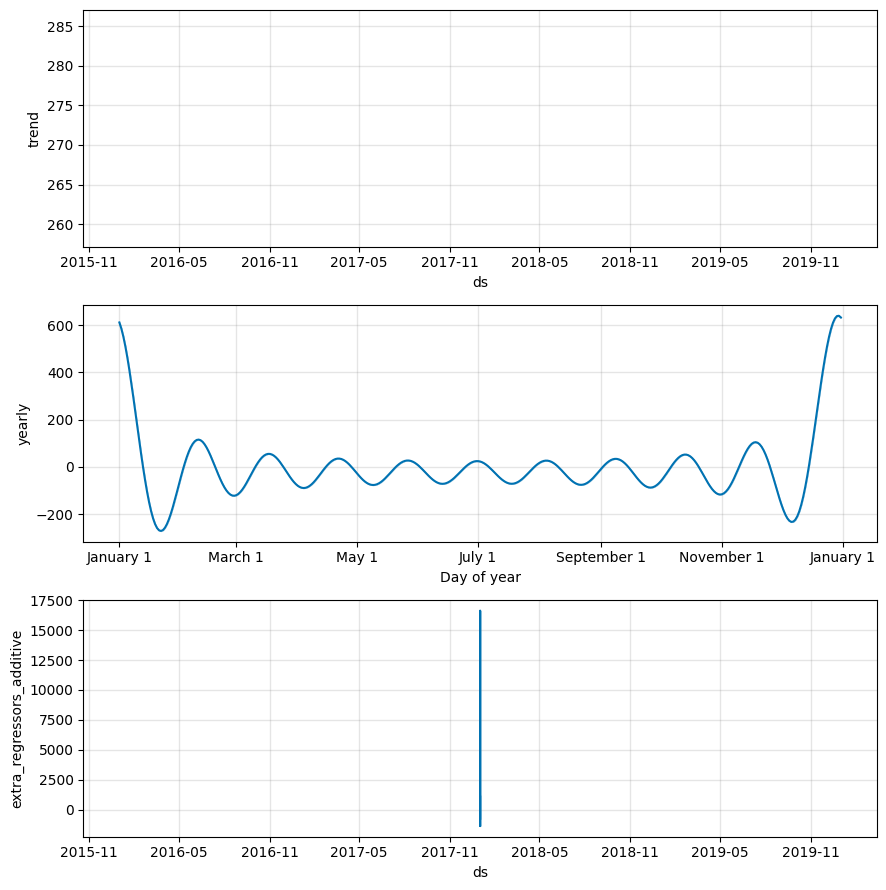

In [162]:
fig = model.plot_components(forecast)

In [95]:
mergefinal.to_excel("economic_data_with150_oho.xlsx")

In [126]:
# import matplotlib.pyplot as plt
# for j in ["A","C"]:
#     for i in missemp:
    
#         # plt.figure()
#         plt.title(i + "    " + j)
#         fig, ax1 = plt.subplots()

#         # Plotting with the primary x-axis (ax1)
#         ax1.plot(mergedboth.loc[(mergedboth["geo"] ==i)&(mergedboth["sector"] ==j), "year"].sort_values(), mergedboth[(mergedboth["geo"] ==i)&(mergedboth["sector"] ==j)].sort_values(by = "year").gdp, color = "red",label="empl")
#         ax1.set_xlabel('Primary x-axis')
#         ax1.set_ylabel('Sin(x)', color='b')

#         # Create secondary x-axis (ax2)
#         ax2 = ax1.twinx()

#         # Plotting on the secondary x-axis (ax2)
#         ax2.plot(mergedboth.loc[(mergedboth["geo"] ==i)&(mergedboth["sector"] ==j), "year"].sort_values(), mergedboth[(mergedboth["geo"] ==i)&(mergedboth["sector"] ==j)].sort_values(by = "year").employment, color = "blue",label="gdp")
#         ax2.set_xlabel('Secondary x-axis')

        
#         # plt.plot(mergedboth.loc[(mergedboth["geo"] ==i)&(mergedboth["sector"] ==j), "year"].sort_values(), mergedboth[(mergedboth["geo"] ==i)&(mergedboth["sector"] ==j)].sort_values(by = "year").employment, color = "blue",label="gdp")
#         plt.legend()

In [123]:
mergedboth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39390 entries, 0 to 39827
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   geo                39390 non-null  object  
 1   year               39390 non-null  int64   
 2   sector             39390 non-null  object  
 3   employment         38200 non-null  float64 
 4   gross value added  39390 non-null  float64 
 5   area               12108 non-null  float64 
 6   gdp                39384 non-null  float64 
 7   population         39390 non-null  float64 
 8   _merge             39390 non-null  category
 9   country            39390 non-null  object  
dtypes: category(1), float64(5), int64(1), object(3)
memory usage: 3.0+ MB


In [ ]:
for i in ['employment', 'gross value added', 'area','gdp', 'population']:
    merged[[year, i]].sort_valu

In [15]:
climate["TIMESTAMP"].apply(lambda x :len(x)).value_counts()

TIMESTAMP
10    441186
Name: count, dtype: int64

In [181]:
climate = pd.read_csv('climate_data_2010_2018.csv')
climate.info()
climate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233214 entries, 0 to 233213
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NUTS_ID                       233214 non-null  object 
 1   TIMESTAMP                     233214 non-null  object 
 2   apara_median                  112025 non-null  float64
 3   heat_intensity_median         69702 non-null   float64
 4   low_flow_index_max            138132 non-null  float64
 5   soil_moisture_anomaly_median  161568 non-null  float64
 6   spi_01_median                 163182 non-null  float64
 7   spi_03_median                 163188 non-null  float64
 8   spi_06_median                 163188 non-null  float64
 9   spi_12_median                 163188 non-null  float64
 10  temp_max_median               141654 non-null  float64
dtypes: float64(9), object(2)
memory usage: 19.6+ MB


NUTS_ID   TIMESTAMP  apara_median  heat_intensity_median  \
0        AL011  2012-01-01        -0.509                    NaN   
1        AL012  2012-01-01        -0.754                    NaN   
2        AL013  2012-01-01        -0.674                    NaN   
3        AL014  2012-01-01        -0.355                    NaN   
4        AL015  2012-01-01        -0.280                    NaN   
...        ...         ...           ...                    ...   
233209   ES704  2011-11-01           NaN                    NaN   
233210   ES708  2011-11-01           NaN                    NaN   
233211   ES703  2011-12-01           NaN                    NaN   
233212   ES704  2011-12-01           NaN                    NaN   
233213   ES708  2011-12-01           NaN                    NaN   

        low_flow_index_max  soil_moisture_anomaly_median  spi_01_median  \
0                    0.705                        -0.149         -0.064   
1                      NaN                        -2.146         -0.098   
2                    0.000                        -2.772          0.059   
3                    0.705                        -2.254         -0.086   
4                    0.000                        -2.649         -0.245   
...                    ...                           ...            ...   
233209                 NaN                           NaN            NaN   
233210                 NaN                           NaN            NaN   
233211                 NaN                           NaN            NaN   
233212                 NaN                           NaN            NaN   
233213                 NaN                           NaN            NaN   

        spi_03_median  spi_06_median  spi_12_median  temp_max_median  
0              -1.310         -1.840         -1.920            3.378  
1              -1.230         -1.855         -2.215           11.434  
2              -1.335         -1.890         -2.215            1.751  
3              -1.210         -2.040         -2.420            7.103  
4              -1.420         -2.170         -2.590            5.050  
...               ...            ...            ...              ...  
233209            NaN            NaN            NaN           26.855  
233210            NaN            NaN            NaN           27.152  
233211            NaN            NaN            NaN              NaN  
233212            NaN            NaN            NaN           24.355  
233213            NaN            NaN            NaN           25.152  

[233214 rows x 11 columns]

In [182]:
climate["TIMESTAMP"] = pd.to_datetime(climate["TIMESTAMP"])
climate["year"] = climate["TIMESTAMP"].apply(lambda x : x.year)
print(climate.loc[climate["apara_median"].isna(), "year"].value_counts())
print(climate.loc[climate["apara_median"].isna(), "NUTS_ID"].value_counts())

year
2010    22845
2011    21279
2015    13606
2018     8838
2022     8374
2016     7680
2012     6694
2014     6193
2017     5528
2019     5388
2013     5163
2020     5097
2021     4504
Name: count, dtype: int64
NUTS_ID
NO0B1    258
MT002    257
ES533    228
EL422    215
EL621    207
        ... 
TR831     24
FRI33     24
MK002     24
PT184     24
TR413     24
Name: count, Length: 1514, dtype: int64


In [187]:
mixspi12 = climate.merge(mergedboth, left_on=["NUTS_ID","year"], right_on =["geo","year"], how ="right")
mixspi12.loc[mixspi12["spi_12_median"].isna(),"geo"].value_counts()

geo
ES703    442
ES708    442
ES704    294
EL422    272
EL621    256
        ... 
FRG02     16
FRG05     16
ES523     16
BE328     12
BE32A     12
Name: count, Length: 1166, dtype: int64

In [151]:
import datetime
climate[pd.to_datetime(climate["TIMESTAMP"]) >= datetime.datetime(2012,1,1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 189258 entries, 0 to 439205
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   NUTS_ID                       189258 non-null  object        
 1   TIMESTAMP                     189258 non-null  datetime64[ns]
 2   apara_median                  112193 non-null  float64       
 3   heat_intensity_median         61914 non-null   float64       
 4   low_flow_index_monthly_max    107436 non-null  float64       
 5   soil_moisture_anomaly_median  125832 non-null  float64       
 6   spi_01_median                 126920 non-null  float64       
 7   spi_03_median                 126924 non-null  float64       
 8   spi_06_median                 126924 non-null  float64       
 9   spi_12_median                 126924 non-null  float64       
 10  temp_max_median               110298 non-null  float64       
 11  year              

In [148]:
print("Summary Stats")
for i in ["A", "C"]:
    for j in mergedboth["geo"].drop_duplicates():
        print(i + "     " + j)
        dataset = mergedboth[(mergedboth["geo"] ==j)&(mergedboth["sector"] ==i)]
        # if dataset.select_dtypes(include=[np.number]).shape[1] > 0: 
        #     display(dataset.describe(include="number").transpose())
        # if dataset.select_dtypes(include=[object]).shape[1] > 0: 
        #     display(dataset.describe(include="object").transpose())
        print(dataset.describe())


Summary Stats
A     AT111
variable         year  employment  gross value added   area         gdp  \
count       17.000000   17.000000          17.000000    6.0   17.000000   
mean      2010.000000    1.135294          39.823529  701.0  787.432941   
std          5.049752    0.276001           6.793704    0.0  114.215163   
min       2002.000000    0.800000          31.000000  701.0  627.480000   
25%       2006.000000    0.900000          35.000000  701.0  714.720000   
50%       2010.000000    1.100000          39.000000  701.0  739.040000   
75%       2014.000000    1.300000          41.000000  701.0  866.410000   
max       2018.000000    1.600000          55.000000  701.0  998.250000   

variable  population  
count      17.000000  
mean       37.564118  
std         0.098746  
min        37.450000  
25%        37.500000  
50%        37.550000  
75%        37.640000  
max        37.730000  
A     AT112
variable         year  employment  gross value added    area          gdp  \
co

In [9]:
print("Summary Stats")
dataset = climate
if dataset.select_dtypes(include=[np.number]).shape[1] > 0: 
    display(dataset.describe(include="number").transpose())
if dataset.select_dtypes(include=[object]).shape[1] > 0: 
    display(dataset.describe(include="object").transpose())



Summary Stats


count       mean       std        min  \
apara_median                  112193.0   0.187631  0.743646  -3.037000   
heat_intensity_median         113730.0   2.045187  1.214286   0.001903   
low_flow_index_monthly_max    276264.0   0.109911  0.257947   0.000000   
soil_moisture_anomaly_median  323568.0   0.005967  0.830512  -4.620000   
spi_01_median                 326368.0   0.010527  0.970449  -4.140000   
spi_03_median                 326376.0   0.007417  0.983636  -3.575000   
spi_06_median                 326376.0   0.023267  0.985977  -3.730000   
spi_12_median                 326376.0   0.058814  0.962933  -3.310000   
temp_max_median               283276.0  15.143450  8.423780 -18.998000   

                                   25%        50%        75%        max  
apara_median                 -0.300000   0.226000   0.715000   3.391000  
heat_intensity_median         1.113782   1.839629   2.769806   8.706688  
low_flow_index_monthly_max    0.000000   0.000000   0.000000   0.999000  
soil_moisture_anomaly_median -0.501000   0.116000   0.589000   3.879000  
spi_01_median                -0.610000   0.058000   0.690500   3.612500  
spi_03_median                -0.652000   0.043000   0.697000   3.574000  
spi_06_median                -0.628000   0.059500   0.701500   3.817000  
spi_12_median                -0.588000   0.065000   0.711000   3.311500  
temp_max_median               8.419000  15.432500  21.690000  41.056000

count unique         top  freq
NUTS_ID    441186   1516       ES707   520
TIMESTAMP  441186   4332  2002-02-01  1878

In [22]:
merged["geo"].apply(lambda x: x[:2]).drop_duplicates().count()

27

In [17]:
# url = "s3://ecb-hackathon-data-group05-x19s00/economic_data/gross_value_added.xlsx"
# s = requests.get(url).content
df = pd.read_excel("s3://ecb-hackathon-data-group05-x19s00/economic_data/gross_value_added.xlsx", skiprows = 8, sheet_name = "Sheet 2")

df =df[ [x for x in df.columns if "Unnamed" not in x]]
df.columns = ['GEO (Codes)','GEO (Labels)', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021']
df = df.iloc[1:]
df = df.iloc[:1338]
df = df[df["GEO (Labels)"]!='Extra-Regio NUTS 3']
df['BE',
 'BG',
 'CZ',
 'DK',
 'DE',
 'EE',
 'IE',
 'EL',
 'ES',
 'FR',
 'HR',
 'IT',
 'CY',
 'LV',
 'LT',
 'LU',
 'HU',
 'MT',
 'NL',
 'AT',
 'PL',
 'PT',
 'RO',
 'SI',
 'SK',
 'FI',
 'SE']

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


GEO (Codes)                                       GEO (Labels) 2002  \
1          BE100  Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad    :   
2          BE211                                     Arr. Antwerpen    :   
3          BE212                                      Arr. Mechelen    :   
4          BE213                                      Arr. Turnhout    :   
5          BE223                                      Arr. Tongeren    :   
...          ...                                                ...  ...   
1334       TRC22                                         Diyarbakir    :   
1335       TRC31                                             Mardin    :   
1336       TRC32                                             Batman    :   
1337       TRC33                                             Sirnak    :   
1338       TRC34                                              Siirt    :   

       2003    2004    2005    2006    2007    2008    2009    2010    2011  \
1       1.2     5.3     3.9     4.4     6.1     2.5    10.9    10.3     9.8   
2     126.4   129.9   107.2   121.7   130.2   105.4     106   134.9   104.8   
3      98.5    83.7    70.9    86.6    99.8    73.3      71    88.5    53.8   
4     273.1   294.3   228.7   284.6   304.4   233.5   219.7   284.1   224.4   
5      87.3    92.9    75.9    91.4   103.9    80.9       :       :       :   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
1334      :  702.31  721.39  694.03  744.68  527.21  666.28  899.33  929.51   
1335      :  320.75  340.59  345.76  375.65  337.03  387.62   657.1  675.59   
1336      :  117.11  135.24  131.98  128.41   92.54  132.31  238.25  226.09   
1337      :  101.84   94.24   84.36  109.12   81.89  126.95  166.34  148.27   
1338      :   68.77   94.01  102.69   98.97   90.19  161.18  208.32  212.43   

        2012    2013    2014    2015    2016    2017    2018    2019    2020  \
1       11.5     8.1    15.2    16.5    14.9    13.7    12.2    12.2    14.9   
2      132.3   117.9   116.6   127.4   124.8   137.5   130.4   151.8     126   
3       65.4    58.8    64.4    73.3    73.4    79.2    93.8   107.4   120.9   
4      297.7   271.3   285.8   328.2   309.6   356.6   346.6   400.1   426.6   
5          :       :       :       :       :   105.1   102.2   109.7   124.4   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1334  975.37  965.49  859.47  946.26     961  966.49  844.53  965.04  961.38   
1335   692.6  644.42  587.09  680.53  630.92  607.79  471.24   507.1  466.16   
1336  238.03  243.26  225.86  238.64  234.87  222.08  202.03  209.92  215.84   
1337  164.13  172.02  150.34  151.01  129.26  151.09  163.16  182.64   194.8   
1338  245.99  229.86  237.28  199.18  170.33  179.71  153.75  209.39  191.42   

        2021  
1         17  
2        123  
3      123.1  
4      432.8  
5      120.5  
...      ...  
1334  832.19  
1335  413.71  
1336  193.41  
1337  177.87  
1338  218.83  

[1324 rows x 22 columns]

In [22]:
df["GEO (Codes)"].apply(lambda x: x[:2]).drop_duplicates().to_list()

['BE',
 'BG',
 'CZ',
 'DK',
 'DE',
 'EE',
 'IE',
 'EL',
 'ES',
 'FR',
 'HR',
 'IT',
 'CY',
 'LV',
 'LT',
 'LU',
 'HU',
 'MT',
 'NL',
 'AT',
 'PL',
 'PT',
 'RO',
 'SI',
 'SK',
 'FI',
 'SE',
 'NO',
 'CH',
 'ME',
 'MK',
 'AL',
 'RS',
 'TR']